# Friend-to-friendネットワークにおける効率的な分散ルーティング
<div style="text-align: right"> 非線形物理学講座　理論神経科学・非平衡系数理グループ B4 髙橋彰</div>
<figure>
    <img class="image" src="data/routing_k(100,0,18,1).png" width=600 >
</figure>
<style>
.image {
    left: 50%;
}
</style>

In [62]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from math import log
import random, logging, sys

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

from utils.gen import kleinberg_ring
from utils.search import greedy_path, average_greedy_path_length, RoutingError
from utils.misc import shuffle_position_ring, dist_ring, labels_from_attr

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, stream=sys.stderr)

def draw_autocrop(G):
    pos = nx.circular_layout(G)
    cut = 1.05
    xmax= cut*max(xx for xx,yy in pos.values())
    ymax= cut*max(yy for xx,yy in pos.values())
    plt.xlim(-xmax,xmax)
    plt.ylim(-ymax,ymax)
    return pos
def draw_autocrop_grid(G):
    pos = dict(zip(G,G))
    cut = 1.05
    xmax= cut*max(xx for xx,yy in pos.values())
    ymax= cut*max(yy for xx,yy in pos.values())
    plt.xlim(-0.3,xmax)
    plt.ylim(-0.3,ymax)
    return pos

# 0. 目次
1. 研究の背景
    - 複雑ネットワークにおけるルーティング
    - P2Pネットワーク
    - F2Fネットワーク
2. 先行研究の紹介
    - Navigable small-world network model (Kleinberg, 2000)
    - Application to the routing in F2F overlay networks (Sandberg, 2006)
3. 今後の課題と改良案

# 1. 研究の背景

## 1.1 背景: 複雑ネットワークにおけるルーティング
- Small-world network - Watts, Strogatz(1998)
    - 高いクラスタリング係数
    - 小さな平均最短経路長: $O(\log n)$
    - 送電網、脳神経、友人関係のネットワーク等現実世界の様々なネットワーク構造に現れる特徴
    
- Navigable small-world network - Kleinberg(2000)
    - 分散的かつ効率的なルーティングを可能にするスモール・ワールドネットワークのモデル
    - P2Pネットワークにおけるルーティングアルゴリズムに応用可能

## 1.1 背景: 複雑ネットワークにおけるルーティング **TODO**
- Scale-free network - Barabasi, Albert(1999) **TODO**
- Routing in scale-free networks - **TODO**: who?

## 1.2 背景: P2Pネットワーク
- クライアント-サーバー方式と比較した, P2Pネットワークのメリット
    - 負荷分散
    - 匿名化
    - 耐障害性

## 1.3 背景: F2Fネットワーク
- Friend-to-friend(F2F)network, Darknet - Clarke et al (2000, 2009)
    - P2Pネットワークの一形態
    - ネットワーク上の各ノードは、信頼のおける特定ノードとのみ直接の通信を行う
    - 匿名性やプライバシーコントロールレベルの向上を目的とする
    - ネットワーク上で隣接していないノード同士がデータの送受信を行うために複数ノードを中継することにより通信効率が犠牲に (c.f. プロキシ)
    - 知り合い関係のネットワークがスモール・ワールド性を持つことを利用
    - Opennet vs Darknet
    - 実装例: Freenet 0.7 or 0.7.5, Retroshare, GNUNet
- 本研究ではF2Fネットワークにおけるルーティングの**効率性**の向上を目指す

# 2. 先行研究の紹介
- Kleinberg, Jon. "The small-world phenomenon: An algorithmic perspective." *Proceedings of the thirty-second annual ACM symposium on Theory of computing*. ACM, 2000.
- Sandberg, Oskar. "Distributed routing in small-world networks." *Proceedings of the Meeting on Algorithm Engineering & Expermiments*. Society for Industrial and Applied Mathematics, 2006.

## 2.1 Navigable small-world network model (Kleinberg, 2000)
### 2.1.1 概要
- Milgramの実験(1967)では各ノードがネットワーク全体の構造を知らずとも少ないホップ数でメッセージをターゲットまで届けることができた
- **分散ルーティング**: 各ノードが局所的な情報のみを利用して次にメッセージを渡すべきノードを決定するルーティング
- Kleinberg(2000)は分散ルーティング可能なスモール・ワールドネットワークの単純なモデルを提唱
- $u,v$間のエッジ存在確率$\propto d(u,v)^{-r}$
- $r$の値が格子の次元に一致する時、シンプルな分散ルーティングアルゴリズムにより$O(\log^2 n)$のホップ数で高確率でターゲットまで辿り着ける

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.2 グラフ生成アルゴリズム
1. サイズ$n$の$k$次元格子$G$を初期状態とする
2. 各ノードは隣接ノードとのエッジを持つ(local contact)
3. $\forall u \in G$に対し$q$本の長距離エッジ(long-range contact)を追加する。ただし$u$が$v$とのエッジを持つ確率を$p(u,v)$として、$p(u,v)=\cfrac{1}{d(u,v)^{r}Z}$とする
    - $r$: パラメータ
    - $d(u,v)$: $u,v$間の格子上での距離
    - $Z$: 正規化定数

In [156]:
%%HTML
<figure>
    <img src="data/kleinberg_long.png", width=500>
    <figcaption>$k=2, q=2$</figcaption>
    <figcaption> Kleinberg, Jon. "The small-world phenomenon: An algorithmic perspective." Proceedings of the thirty-second annual ACM symposium on Theory of computing. ACM, 2000. </figcaption>
</figure>

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.3 分散ルーティング
- 分散ルーティング: 各ノードが自らが保持している情報のみを用いて行うルーティング
    - 広義には隣接ノードとルーティングテーブルを交換するやDVAやLSAなども含まれる
    - 対義語: 中央集権的 (centralized) ルーティング
- Kleinbergは分散ルーティングにおいて各ノードが知っている情報を以下のように制限
    1. 自分の格子上における位置
    2. ターゲットの格子上における位置
    3. 隣接ノードの格子上における位置
- **Greedyルーティング**
    - メッセージを受け取ったノードは隣接ノードの中で最もターゲットに近いノードを次ノードとして選択するシンプルなアルゴリズム

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.4 分散ルーティング効率に関する3つの結果
1. $r=k$のとき, Greedyルーティングによるターゲットへのホップ数は$O(\log^2 n)$
2. $0 \leq r < k$のとき, どのような分散ルーティングアルゴリズムを用いてもターゲットへのホップ数は$\Omega(n^{(2-r)/3)})$
3. $k < r$のとき, どのような分散ルーティングアルゴリズムを用いてもによるターゲットへのホップ数は$\Omega(n^{(r-2)/(r-1))})$

In [82]:
%%HTML
<figure>
    <img src="data/kleinberg_lowerbound.png", width=700>
    <figcaption> Kleinberg, Jon. "The small-world phenomenon: An algorithmic perspective." Proceedings of the thirty-second annual ACM symposium on Theory of computing. ACM, 2000. </figcaption>
</figure>

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.5 例: 2次元の場合

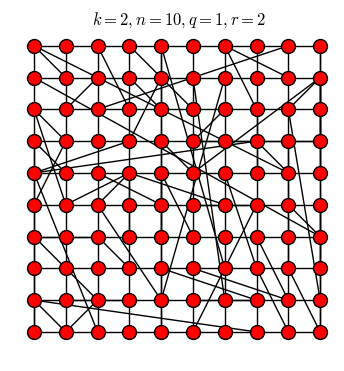

In [63]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: right;
    vertical-align: middle;
}
</style>
""")
plt.rcParams['figure.figsize'] = (4,4)
G = nx.navigable_small_world_graph(10, p=1, q=1, r=2, dim=2)
G = G.to_undirected()
pos=draw_autocrop_grid(G)
plt.title("$k=2, n=10, q=1, r=2$")
nx.draw(G, pos=dict(zip(G,G)), node_size=100, node_color='r')

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.5 例: 1次元の場合

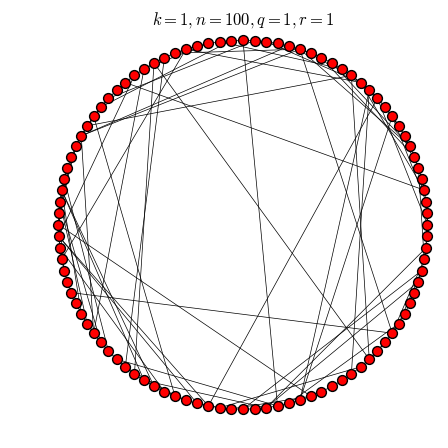

In [14]:
plt.rcParams['figure.figsize'] = (5,5)
G = kleinberg_ring(100, p=1, q=1, r=1)
pos = draw_autocrop(G)
plt.title("$k=1, n=100, q=1, r=1$") 
nx.draw_circular(G, with_labels=False, node_size=50, node_color='r', width=0.5)

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.1 概要
- スモール・ワールドネットワーク上でのルーティング→F2Fオーバーレイネットワーク上でのルーティング
- 信頼関係によるF2Fネットワークを構築した場合スモール・ワールド性を持つと仮定(例: Web of Trust)
- Kleinberg(2000)では各ノードが自分の格子上での位置を知っていることが前提となっている
    - コンピュータのオーバーレイネットワークではこの前提が成り立たない
    - 各ノードに格子上の位置を知らせる必要がある
    
- **Kleinbergモデルの復元**
    - 元のグラフを1次元or2次元格子上に埋め込む(*embedding*)
    - Kleinbergのモデルによって生起する確率が高くなるような配置を**MCMC**により求める
    - 各ノードの配置決定後、分散ルーティングを実行
- Freenet ver. 0.7/0.7.5の基礎となる手法を提起
    - 1次元格子(リングトポロジー)をbase graphとして採用
    - 各ノードのIDがリング上における位置に対応: $id(v) \in [0,1)$

In [117]:
%%HTML
<figure>
    <img src="data/ict_fig_300.png", width=800>
    <figcaption class="caption">Overview of the method proposed in Sandberg(2006)</figcaption>
</figure>
<style>
.caption {
    width: 800px;
    text-align: center;
}
</style>

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.2 用語
- *base graph*
- *embedding*
- *reverse engineering*
- *location swapping*
- *dead-end*
- *local/long-range contact*

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.2 問題設定
- 「Kleinbergモデルで生成されたネットワークトポロジーが与えられ、かつ各ノードの格子上における座標情報がないとき、効率的な分散ルーティングが可能になるように座標情報を復元する」
    - → 配置$\phi$のパラメータ推定問題としてみなす
- $H = (V, E)$: 解析対象となるネットワーク ($E=\{1, 2,\ldots, m\}$とする)
- $G$: $k$次元格子, base graph
- $\phi$:  $V \to G$, パラメータ, 格子における元ノードの配置に対応
- $\textrm{Pr} (E|\phi)= \displaystyle\prod_{i=1}^{m}\cfrac{1}{d(\phi(u_i), \phi(v_i))^{k}Z}$: 尤度関数
- $\textrm{Pr}(\phi|E) = \cfrac{\textrm{Pr}(E|\phi)\textrm{Pr}(\phi)}{\textrm{Pr}(E)}$: 事後分布

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.3 手法 - Metropolis-Hastings アルゴリズム
- Metropolis-Hastingsアルゴリズムによりembedding $\phi$をサンプリング
- $\phi_1$を現在の値, $\phi_2$を次の値候補として以下のように導かれた採択確率$\beta(\phi_1, \phi_2)$を用いる

In [168]:
%%latex
\begin{eqnarray*}
    \beta (\phi_1, \phi_2) &=& \min \left[1, \cfrac{\textrm{Pr}(\phi_2|E)\alpha(\phi_2, \phi_1)}{\textrm{Pr}(\phi_1|E)\alpha(\phi_1, \phi_2)}\right] \\
                           &=& \min \left[1, \cfrac{\textrm{Pr}(\phi_2|E)}{\textrm{Pr}(\phi_1|E)}\right] \\
                           &=&  \min \left[1, \cfrac{\textrm{Pr}(E|\phi_2)}{\textrm{Pr}(E|\phi_1)}\right] \\
                           &=& \min \left[1, \prod_{i=1}^{m}\cfrac{d(\phi_1(u_i), \phi_1(v_i))^k}{d(\phi_2(u_i), \phi_2(v_i))^k}\right] \\
                           &=& \min \left[1, \prod_{i \in E(x \vee y)}^{}\cfrac{d(\phi_1(u_i), \phi_1(v_i))^k}{d(\phi_2(u_i), \phi_2(v_i))^k}\right] \\
\end{eqnarray*}


<IPython.core.display.Latex object>

- ここで,
    - $\phi_1(x)=\phi_2 (y), \phi_1(y)=\phi_2 (x)$, and for all $z \neq x, y, \phi_1(z)=\phi_2(z)$ (つまり$\phi_2$は$\phi_1$の$x,y$の配置を入れ替えたもの)
    - $E(x \vee y)$ : $x$または$y$を端点に持つエッジの集合
    - $\alpha(\phi_1, \phi_2 ) = \alpha(\phi_2, \phi_1 )  =  \frac{1}{\left(n + \left( \begin{array}{c} n \\ 2 \end{array} \right)\right)}$  if $x,y$-switch, 0 otherwise : 提案分布, シンメトリック
    
 とする

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.3 Metropolis-Hastings アルゴリズム

In [132]:
%%HTML
<figure>
    <img src="data/sandberg_switch.png", width=800>
     <figcaption class="caption">Node switch</figcaption>
     <figcaption class="caption">Sandberg, Oskar. "Distributed routing in small-worlds - Darknet", 2006</figcaption>
</figure>
<style>
.caption {
    width: 800px;
    text-align: center;
}
</style>

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.4 深さ優先探索
- Kleinbergのモデルでは必ずlocal-contactが存在すると仮定しているため, ターゲットまでの距離は狭義に単調減少する
- しかし実データでこの仮定は成り立たないため, 行き止まり(*dead-end*)になる可能性がある
- 行き止まりに対応するためのルーティングアルゴリズムとして、ホップ数上限付の深さ優先探索を用いる
    1. リクエストの内容が過去に受け取ったものと同一であればリクエストを拒否。さもなくば2へ。
    2. 自分がターゲットである or ホップ数上限に達していれば終了。さもなくば3へ。
    3. 隣接ノードのうちターゲットに一番近いノードへリクエストをフォワード (Greedyルーティング)
    4. リクエストが拒否された場合、拒否したノードを候補から外し3を繰り返す。
    

- c.f. 実際のFreenetの実装で使われるルーティングアルゴリズムは以下の通り(Evans, 2007): **TODO** pseudo code
    1. リクエストの内容が過去に一度来たものかどうかチェック。もし同じリクエストであれば, リクエストを拒否。
    2. 自分がターゲットであれば終了。さもなくば3へ
    3. もし現在の位置がリクエストがそれまでに辿ってきたどのノードの位置よりもターゲットに近ければ$HTL$(hops-to-live)をリセット
    4. もしHTLが0になればリクエスト失敗を返す。さもなくば5.へ
    5. 自分の隣接ノードからターゲットに一番近いノードにリクエストをフォワードし, リクエストにHTL-1と自分のノードIDを付加

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション
#### 2つの実験
1. 人工的に生成したデータにM-Hアルゴリズムを適用
2. 実データ(Web of Trust)にM-Hアルゴリズムを適用

#### 3パターンのルーティングアルゴリズム
- Fail(F): dead-endに到達した時点でルーティング失敗とする
- Local Contact(LC): base graph上のlocal contactの使用を許す(Kleinbergの論文の手法と同様)
- Continue(C): 深さ優先探索。dead-endに到達したら隣接ノード中で最も近いノードを次のノードとして選択。

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション - 1. 人工的に生成したデータ
- *start*: Kleinbergのモデルに従って生成された直後のグラフ
- *random*: *start*の配置をランダムに入れ替えたグラフ
- *restored*: *random*にM-Hアルゴリズムを適用し, $6000n$回反復を行った後のグラフ

In [166]:
%%HTML
<figure class="onedim">
    <img src="data/sandberg_2006_1dim_start.png">
    <figcaption class="onedimcap">start</figcaption>
</figure>
<figure class="onedim">
    <img src="data/sandberg_2006_1dim_random.png">
     <figcaption class="onedimcap">random</figcaption>
</figure> 
<figure class="onedim">
    <img src="data/sandberg_2006_1dim_restored.png">
     <figcaption class="onedimcap">restored</figcaption>
</figure> 
<style>
.onedim {
    width: 33.3%;
    float: left;
    margin: 0;
    text-align: left;
    padding: 0;
}
.onedimcap {
    text-align: center;
}
</style>


## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション - 1. 人工的に生成したデータ
- *start*: Kleinbergのモデルに従って生成された直後のグラフ
- *random*: *start*の配置をランダムに入れ替えたグラフ
- *restored*: *random*にM-Hアルゴリズムを適用し, $6000n$回反復を行った後のグラフ

In [133]:
%%HTML
<figure class="subfig">
    <img src="data/sandberg_2006_fig1.png">
</figure>
<figure class="subfig">
    <img src="data/sandberg_2006_fig2.png">
</figure> 
<style>
.subfig {
    width: 45%;
    float: left;
    margin: 0;
    text-align: left;
    padding: 0;
}
</style>

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション - 1. 人工的に生成したデータ
- *start*: Kleinbergのモデルに従って生成された直後のグラフ
- *random*: *start*の配置をランダムに入れ替えたグラフ
- *restored*: *random*にM-Hアルゴリズムを適用し, $6000n$回反復を行った後のグラフ

In [154]:
%%HTML
<figure class="subfig">
    <img src="data/sandberg_2006_fig3.png">
</figure>
<figure class="subfig">
    <img src="data/sandberg_2006_fig4.png">
</figure> 

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション - 1. 人工的に生成したデータ
- *start*: Kleinbergのモデルに従って生成された直後のグラフ
- *random*: *start*の配置をランダムに入れ替えたグラフ
- *restored*: *random*にM-Hアルゴリズムを適用し, $6000n$回反復を行った後のグラフ

In [136]:
%%HTML
<figure class="subfig">
    <img src="data/sandberg_2006_fig12.png">
</figure>

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション - 2. 実データ (PGP公開鍵ネットワーク: Web of Trust)
- Web of Trust: PGP公開鍵の信頼性を保証するための仕組み。現実世界における知り合い関係のネットワークに対応する。
    - ノード: 公開鍵の所有者
    - エッジ: ノード間でデジタル署名が行われていれば存在(有向)
- 本論文では2000ノードと4000ノードをサンプルとして抽出しテストを行った

In [153]:
%%HTML
<figure class="table">
    <img src="data/sandberg_2006_table1.png">
</figure> 
<figure class="wot">
    <img src="data/wot.gif">
</figure>

<style>
.wot {
    width: 45%;
    float: left;
    margin: 0;
    text-align: left;
    padding: 0;
}
.table {
    width: 30%;
    float: left;
    margin: 0;
    text-align: left;
    padding: 0;
}
</style>

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.6 結論
- 提案されたM-Hアルゴリズムによってノードの位置交換を繰り返すことで, 効率の良い分散ルーティングが可能になる
- 人工的に生成されたデータに対しては, M-Hアルゴリズム適用の結果, 理想的な配置におけるホップ数に近づけることができる
- 実データに関しては多数のリーフノードの存在により, dead-endに到達することが多く, Greedyアルゴリズムでは非効率となってしまう
    - ただし実データを対象にした他の先行研究の結果は成功率が更に低い
        - Liben-Nowell et al. (2005): 13%
        - Milgram (1967): 20%

# 3. 追試結果
- Sandberg(2006)の手法を用いた実データの解析結果

# 3. 今後の課題と改良案
- Kleinberg(2000)のモデルはlocal contactが必ず存在するという仮定の上ルーティングが機能するとしているが、現実的ではない。またスケールフリー性も無視している。
    - より現実的なモデルをembedding先として用いる (例: Kleinberg(2002), Watts et al. (2002))
- M-Hアルゴリズムにおいて, 位置を入れ替えるノードの選択が分散的でない
    - 分散的に実装可能でかつ収束効率の良い提案分布を設定する必要性
- Web of Trust以外の社会ネットワークデータに対する実験
- 現実のネットワークは通信速度等を考慮して重み付きエッジを用いるべき

## Freenet 0.7/0.7.5 の課題
    1. 効率性
        - モデルと現実のネットワークのトポロジーの差異によるembeddingしてもルーティングが必ずしもうまく行かない
    2. 安全性
        - アタッカーノードの存在を仮定した場合、安全性が保たれない
    3. 頑健性
        - 実際のネットワークは静的でなく、動的にノードが出入りする(=churn)。 この場合ルーティングの効率性が保証されない (Evans, 2007)